# DCGAN

[notebook](https://github.com/nttuan8/GAN_Tutorial/blob/master/G2/DCGAN.ipynb)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from tqdm import tqdm_notebook

from keras.models import Sequential,Model
from keras.layers import Input,ReLU,LeakyReLU,Dense,BatchNormalization
from keras.layers.core import Activation, Reshape, Flatten
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.datasets import cifar10
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD

In [67]:
def build_generator(z_dim=128,n_filter=64):
    init = RandomNormal(stddev=0.02)
    
    G = Sequential()
    G.add(Dense(2*2*n_filter*8, input_shape=(z_dim,), use_bias=True, kernel_initializer=init))
    
    # 2*2*512
    G.add(Reshape((2,2,n_filter*8)))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 4*4*256
    G.add(Conv2DTranspose(n_filter*4,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 8*8*128
    G.add(Conv2DTranspose(n_filter*2,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 16*16*128
    G.add(Conv2DTranspose(n_filter,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 32*23*3
    G.add(Conv2DTranspose(3,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(Activation('tanh'))
    
    print('Build Generator')
    print(G.summary())
    
    return G

In [68]:
# Test generator
generator = build_generator(z_dim=128,n_filter=64)

Build Generator
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2048)              264192    
_________________________________________________________________
reshape_4 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_26 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 4

In [69]:
def build_discriminator(input_shape=(32,32,3),n_filter=64):
    
    init = RandomNormal(stddev=0.02)
    
    D = Sequential()
    
    # 16*16*64
    D.add(Conv2D(n_filter,input_shape=input_shape, kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(LeakyReLU(0.2))
    
    # 8*8*64
    D.add(Conv2D(n_filter*2,input_shape=input_shape,kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 4*4*64
    D.add(Conv2D(n_filter*4,input_shape=input_shape,kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 2*2*64
    D.add(Conv2D(n_filter*8,input_shape=input_shape,kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    D.add(Flatten())
    D.add(Dense(1,kernel_initializer=init))
    D.add(Activation('sigmoid'))
    
    print('Build Discriminator')
    print(D.summary())
    
    return D

In [70]:
# Test Discriminator
discriminator = build_discriminator(input_shape=(32,32,3),n_filter=64)

Build Discriminator
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_31 (Batc (Non

In [71]:
def get_data():
    (X_train,y_train),(X_test,y_test) = cifar10.load_data()
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = 2*(X_train/255)-1
    X_test = 2*(X_test/255)-1
    return X_train,X_test

In [72]:
def plot_images(images,filename):
    h, w, c = images.shape[1:]
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images + 1) / 2. *255.
    images = images.astype(np.uint8)
    images = (images.reshape(grid_size,grid_size,h,w,c)
             .transpose(0,2,1,3,4)
             .reshape(grid_size*h,grid_size*w,c))
    plt.imsave(filename,images)
    plt.imshow(images)
    plt.show()

In [73]:
def plot_losses(losses_d,losses_g,filename):
    fig,axses = plt.subplots(1,2,figsize=(8,2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title('losses_d')
    axes[1].set_title('losses_g')
    plt.tight_layout()
    plt.savefig(filename)

In [74]:
def train(n_filter=64, z_dim=100, lr_d=2e-4, lr_g=2e-4, epochs=300, batch_size=128,     
          epoch_per_checkpoint=1, n_checkpoint_images=36, verbose=10):
    X_train,_ = get_data()
    image_shape = X_train[0].shape
    print('Image shape {}, min val {}, max val {}'.format(image_shape, np.min(X_train[0]), np.max(X_train[0])))
    
    plot_images(X_train[:n_checkpoint_images], 'real_image.png')
    
    # Build model
    G = build_generator(z_dim, n_filter)
    D = build_discriminator(image_shape, n_filter)
    
    # Loss for discriminator
    D.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # D(G(X))
    D.trainable = False
    z = Input(shape=(z_dim,))
    D_of_G = Model(inputs=z, outputs=D(G(z)))
    
    # Loss for generator
    D_of_G.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # Labels for computing the losses
    real_labels = np.ones(shape=(batch_size, 1))
    fake_labels = np.zeros(shape=(batch_size, 1))
    losses_d, losses_g = [], []
    
    # fix a z vector for training evaluation
    z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
    
    for e in tqdm_notebook(range(1, epochs+1)):
        n_steps = X_train.shape[0]//batch_size
        for i in range(n_steps):
            # Train discriminator
            D.trainable = True
            real_images = X_train[i*batch_size:(i+1)*batch_size]
            loss_d_real = D.train_on_batch(x=real_images, y=real_labels)[0]
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            fake_images = G.predict_on_batch(z)
            loss_d_fake = D.train_on_batch(x=fake_images, y=fake_labels)[0]
            
            loss_d = loss_d_real + loss_d_fake
            
            # Train generator
            
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=real_labels)[0]
            
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            
            
            if i == 0 and e%verbose == 0:
                print('Epoch {}'.format(e))
                fake_images = G.predict(z_fixed)
                #print("\tPlotting images and losses")
                plot_images(fake_images, "Images1/fake_images_e_{}.png".format(e))
                #plot_losses(losses_d, losses_g, "losses.png")


Image shape (32, 32, 3), min val -1.0, max val 1.0


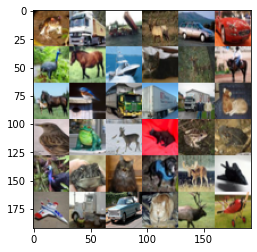

Build Generator
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 2048)              206848    
_________________________________________________________________
reshape_6 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_42 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 4

<ipython-input-74-a0b61002d817>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epochs+1)):


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [77]:
train()

### References

[Bài 2: Deep Convolutional Generative Adversarial Network (DCGAN)](https://nttuan8.com/bai-2-deep-convolutional-gan-dcgan/)

[Bài 3: Conditional GAN (cGAN)](https://nttuan8.com/bai-3-conditional-gan-cgan/)

[Bài 4: Least Squares Generative Adversarial Networks (LSGAN)](https://nttuan8.com/bai-4-least-squares-generative-adversarial-networks-lsgan/)

[Bài 5: GAN evaluation](https://nttuan8.com/bai-5-gan-evaluation/)